# Collaboration and Competition

---

In this notebook, I provide a solution to the third project in Udacity's Deep Reinforcement Learning Nanodegree.

My solution uses a single actor-critic style DDPG agent as the "brain" for both of the players in the game because in this game the observations for the two players are symetrical, and the players should react to the same state inputs with the same actions.

Both player's experiences are stored in a single replay buffer for the DDPG agent to learn. As shown below, the agent is able to solve the environment in 1500 episodes (100_episode_average_score=0.5), and further improves the score to 1.4+ at 1812 episode.

Here I show the recorded actions of the agent before and after the training. It seems the agent learned to play the game pretty well.

### Before Training
![title](img/before_training.gif)

### After Training
![title](img/after_training.gif)

### 0. Start the environment and agent

We begin by importing the necessary packages, and initiate the enviroment as well as the DDPG agent.

In [1]:
import torch
import numpy as np
from collections import deque
from unityagents import UnityEnvironment
from ddpg_agent import Agent
import matplotlib.pyplot as plt

%matplotlib inline

# instantiate the environment and agent
env = UnityEnvironment(file_name='Tennis.app')
agent = Agent(state_size=24, action_size=2, random_seed=2)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# get the number of agents in the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 1. Show the network archetecture

In [5]:
print('Local Actor Network:\n', agent.actor_local, '\n')
print('Target Actor Network:\n', agent.actor_target, '\n')
print('Local Critic Network:\n', agent.critic_local, '\n')
print('Target Critic Network:\n', agent.critic_target, '\n')

Local Actor Network:
 Actor(
  (normalizer): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
) 

Target Actor Network:
 Actor(
  (normalizer): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
) 

Local Critic Network:
 Critic(
  (normalizer): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fcs1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=66, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
) 

Target Critic Network:
 Critic(
  (normalizer): BatchNorm1d(24, eps=1e-0

### 2. Define training process details

#### Hyper Parameters
- BUFFER_SIZE = 100000 (replay buffer size)
- BATCH_SIZE = 300 (minibatch size)
- GAMMA = 0.99 (discount factor)
- TAU = 1e-3 (for soft update of target parameters)
- LR_ACTOR = 1e-4 (learning rate of the actor)
- LR_CRITIC = 1e-3 (learning rate of the critic)

In [2]:
def ddpg(n_episodes=2000, print_every=400):
    
    scores_deque = deque(maxlen=100)
    scores = []
    best_score = 0
    environment_solved = False
    environment_solved_episode = 0
    best_performance_episode = 0
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        while True:
            if i_episode > 1000:
                actions = agent.act(states, noise_level=0)
            else:
                actions = agent.act(states, noise_level=1)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.memorize(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            agent.learn()
            if np.any(dones):
                break
        episode_score = np.max(score)
        scores_deque.append(episode_score)
        scores.append(episode_score)
        
        if (not environment_solved) and np.mean(scores_deque)>0.5 :
            environment_solved_episode = i_episode
            environment_solved = True
        
        if np.mean(scores_deque) > best_score:
            torch.save(agent.actor_local.state_dict(), 'best_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'best_critic.pth')
            best_score = np.mean(scores_deque)
            best_performance_episode = i_episode
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    
    print(
        'Environment solved in {} episodes. Best average score of {} reached at {} episodes.'.format(
            environment_solved_episode, best_score, best_performance_episode))
    
    return scores

### 3. Start the training and plot the scores

Episode 400	Average Score: 0.01
Episode 800	Average Score: 0.06
Episode 1200	Average Score: 0.11
Episode 1600	Average Score: 1.25
Episode 2000	Average Score: 0.62
Environment solved in 1500 episodes. Best average score of 1.4174000211805104 reached at 1812 episodes.


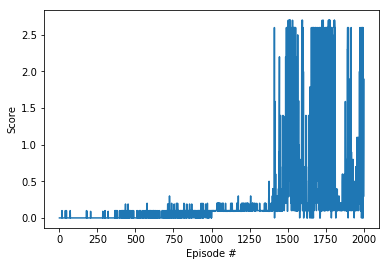

In [3]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### 4. Future ideas

During the training I found that the replay buffer size is critical to the stability of the learning. When the buffer size is set to a small value, the agent's single successful episode could fill up the buffer, and force the agent to learn from only that episode's data which led to unstatble scores. This makes me realize that what the agent learns from is extremely important for the stability of the training. So to further improve the scores, I believe the prioritization of the replay buffer experiences would do the magic.